C:\Users\luvra\AppData\Local\Temp\ipykernel_18668\47392882.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed


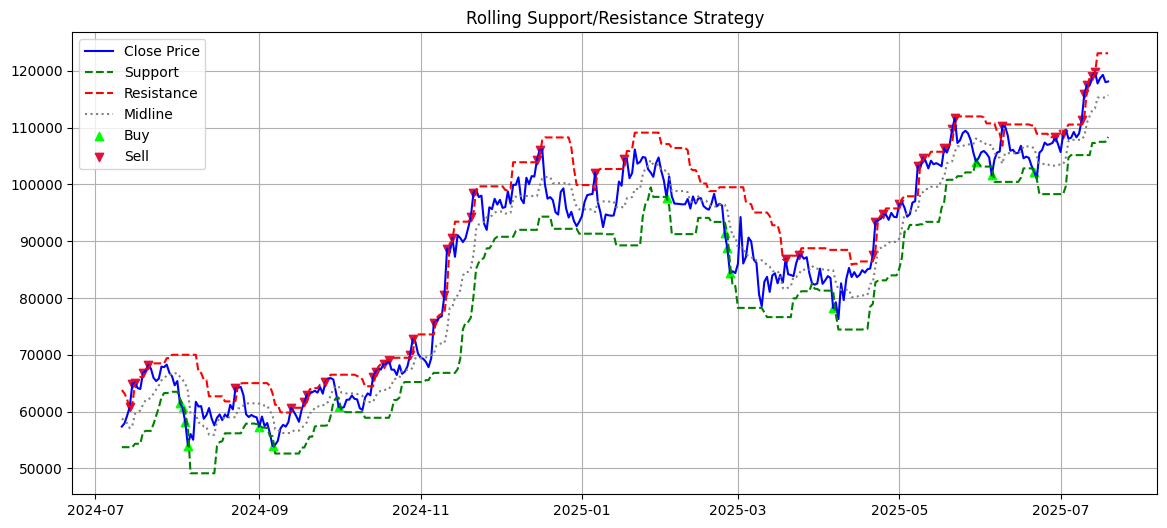

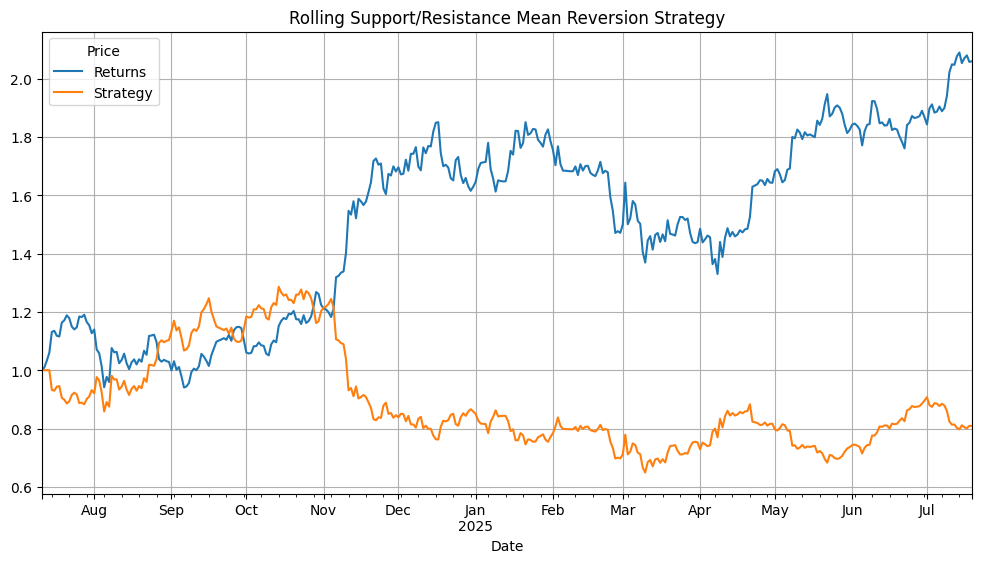

In [646]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = "BTC-USD"
start = "2024-07-01"
end = "2025-07-20"

def download_data(start, end, ticker):
    data = yf.download(ticker, start=start, end=end, interval="1d")
    if data.empty:
        print("No data fetched. Check ticker, interval, or date range.")
        return pd.DataFrame()
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data



def compute_rolling_levels(data, window=20):
    data['Support'] = data['Low'].rolling(window).min().shift(1)
    data['Resistance'] = data['High'].rolling(window).max().shift(1)
    data['Mid'] = (data['Support'] + data['Resistance']) / 2
    return data


def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0
    data.loc[data['Close'] <= data['Support'], 'Signal'] = 1
    data.loc[data['Close'] >= data['Resistance'], 'Signal'] = -1

    # Exit: -1 to close long, +1 to close short
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = download_data(start=start, end=end, ticker=ticker)
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)


In [647]:
df

Price,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy
Date,,,,,,,,,,,,,
2024-07-11,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN
2024-07-12,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000
2024-07-13,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000
2024-07-14,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000
2024-07-15,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293
2025-07-16,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162
2025-07-17,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643


In [648]:
import numpy as np

df["returns_difference"] = df["Returns"].diff()
df["trend_direction"] = np.where(df["returns_difference"].shift(-1) > 0, 1, 0)


In [649]:
df

Price,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction
Date,,,,,,,,,,,,,,,
2024-07-11,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN,NaN,1
2024-07-12,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000,0.009670,1
2024-07-13,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000,0.013343,1
2024-07-14,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000,0.003253,1
2024-07-15,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158,0.040891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293,-0.023451,1
2025-07-16,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162,0.025455,0
2025-07-17,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643,-0.003519,0


In [650]:
from sklearn.model_selection import train_test_split

In [651]:
from sklearn.preprocessing import StandardScaler

In [652]:
X = df.iloc[:,1:6].to_numpy()
Y = df.iloc[:,-1].to_numpy()
X,Y

(array([[5.92994336e+04, 5.71203789e+04, 5.77298906e+04, 2.87078038e+10,
         5.37173750e+04],
        [5.85325547e+04, 5.65901758e+04, 5.73411953e+04, 2.56048052e+10,
         5.37173750e+04],
        [5.97870781e+04, 5.77964414e+04, 5.79087383e+04, 1.70800618e+10,
         5.37173750e+04],
        ...,
        [1.20999609e+05, 1.17508219e+05, 1.18738508e+05, 7.23638418e+10,
         1.07499555e+05],
        [1.20851914e+05, 1.16925984e+05, 1.19284109e+05, 7.79457998e+10,
         1.07499555e+05],
        [1.18540445e+05, 1.17712625e+05, 1.18002219e+05, 5.09522698e+10,
         1.08357680e+05]], shape=(374, 5)),
 array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
     

In [653]:
X.shape, Y.shape

((374, 5), (374,))

In [654]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [655]:
X_train

array([[6.23710234e+04, 6.16895820e+04, 6.20676094e+04, 1.33054107e+10,
        5.98788047e+04],
       [9.45357344e+04, 9.19629609e+04, 9.34275859e+04, 4.17195688e+10,
        8.30270078e+04],
       [8.11190625e+04, 7.44366797e+04, 7.82213359e+04, 9.12624250e+10,
        7.70977422e+04],
       ...,
       [6.17786602e+04, 5.83488242e+04, 6.09448906e+04, 2.27597548e+10,
        4.91212383e+04],
       [1.06182547e+05, 1.02822023e+05, 1.05924594e+05, 6.95504408e+10,
        1.00436883e+05],
       [1.11798906e+05, 1.06841305e+05, 1.11679359e+05, 6.75481334e+10,
        1.01440812e+05]], shape=(299, 5))

In [656]:
from sklearn.linear_model import LogisticRegression

In [657]:
sc = StandardScaler()

In [658]:
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-1.40570322, -1.29121031, -1.34529409, -1.35722868, -1.1400974 ],
       [ 0.37354794,  0.41057502,  0.40723457, -0.12582799,  0.19087094],
       [-0.36862037, -0.57464597, -0.44255525,  2.02123923, -0.15004817],
       ...,
       [-1.4384709 , -1.4790074 , -1.40803638, -0.94750034, -1.75863268],
       [ 1.01781316,  1.0210055 ,  1.10562044,  1.0802945 ,  1.19189863],
       [ 1.32849259,  1.24694506,  1.42722118,  0.99351935,  1.24962228]],
      shape=(299, 5))

In [659]:
model = LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

In [660]:
Y_pred = model.predict(X_test)


In [661]:
Y_test

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0])

In [662]:
Y_pred

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1])

In [663]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.67


In [664]:
df["predicted_direction"] = model.predict(X)

In [665]:
df

Price,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction,predicted_direction
Date,,,,,,,,,,,,,,,,
2024-07-11,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN,NaN,1,1
2024-07-12,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000,0.009670,1,1
2024-07-13,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000,0.013343,1,1
2024-07-14,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000,0.003253,1,1
2024-07-15,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158,0.040891,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293,-0.023451,1,1
2025-07-16,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162,0.025455,0,1
2025-07-17,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643,-0.003519,0,1


In [666]:
df.drop(columns=["Signal", "Exit", "Position", "Returns", "Strategy", "returns_difference", "trend_direction"], inplace=True)

In [667]:
df

Price,Close,High,Low,Open,Volume,Support,Resistance,Mid,predicted_direction
Date,,,,,,,,,
2024-07-11,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,1
2024-07-12,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,1
2024-07-13,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,1
2024-07-14,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,1
2024-07-15,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,1
...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,1
2025-07-16,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,1
2025-07-17,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,1


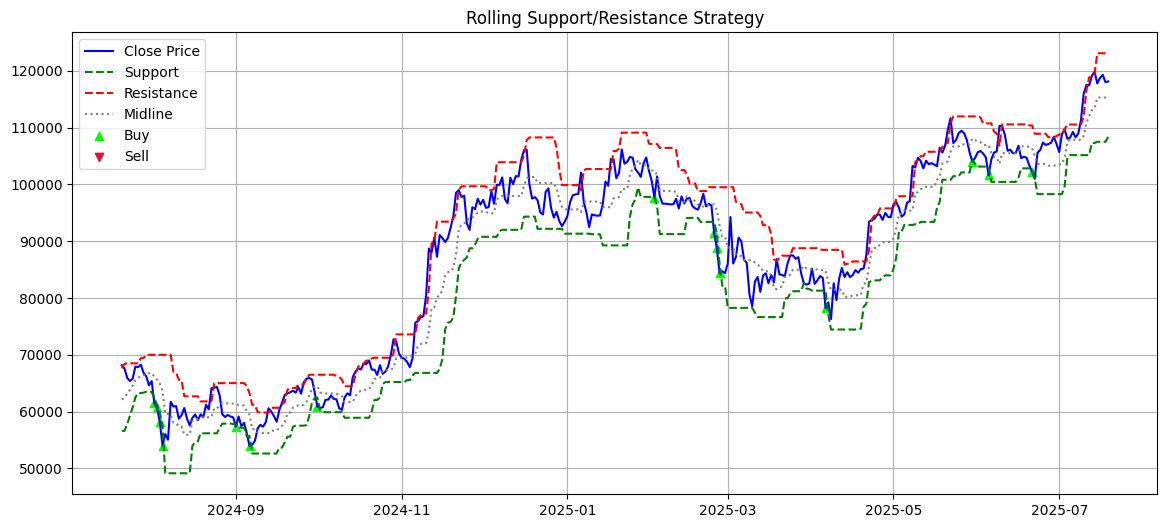

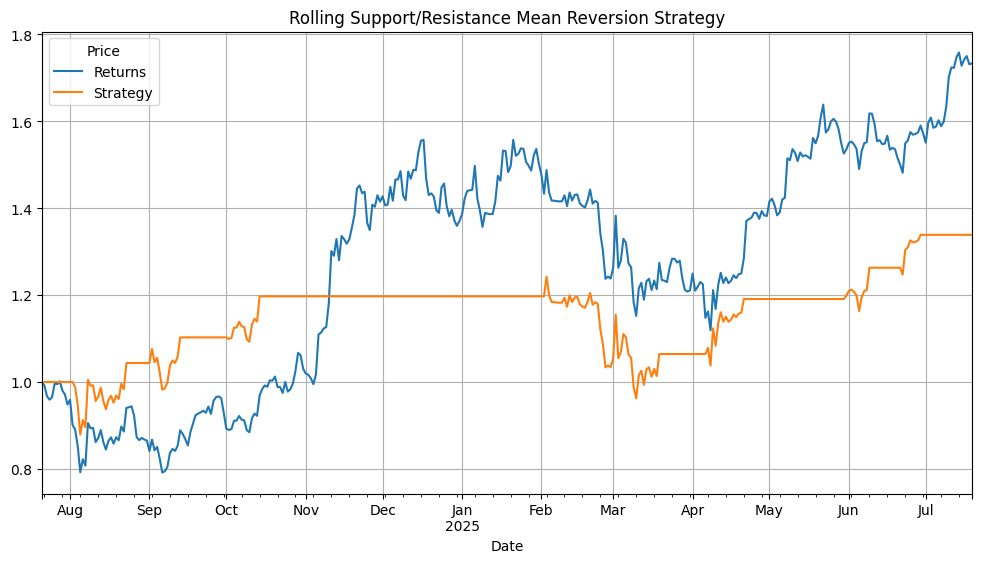

In [668]:

def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0

    # Long Entry Condition
    data.loc[
        (data['Close'] <= data['Support']) &
        (data['predicted_direction'] == 1),
        'Signal'
    ] = 1

    # Short Entry Condition
    data.loc[
        (data['Close'] >= data['Resistance']) &
        (data['predicted_direction'] == 0),
        'Signal'
    ] = -1

    # Exit logic
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)